# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1. Low dimension / low data (no fancy sampling)

Problem in 1-d: $f_{BlackBox}(x) = 2*sin(x) - x$ at threshold $t=3.$

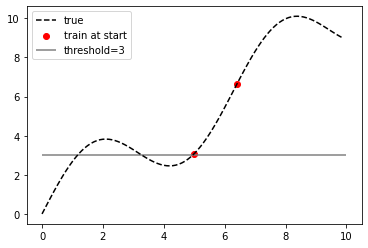

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import Tensor
from botorch.utils import standardize

def f(x: Tensor):
    return 2*torch.sin(x)+x

#generate truth data
true_x = torch.arange(0, 10, 0.1).double()
true_y = f(true_x).double()

#generate std training data
train_x = 10*torch.rand(2,1).double()
train_y = f(train_x).double()
train_x_std = standardize(train_x).double()
train_y_std = standardize(train_y).double()

#plot
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.hlines(3, 0, 10, color='grey', label='threshold=3');
plt.legend();

In [4]:
#train model 
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

gp = SingleTaskGP(train_x, train_y_std);
mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
fit_gpytorch_model(mll);

In [5]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import ScalarizedObjective
from botorch.models.model import Model
from typing import Optional
import numpy as np
import math

def cdf(mu, sigma, t):
    #DEBUG: use torch.erfc for numerical stability?
    erf = torch.erf((t - mu) * sigma.reciprocal() / math.sqrt(2))
    cdf = 0.5 * (1 + erf)
    return cdf.double()

class MaximumEntropySearch(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        thresholds: list,
        objective: Optional[ScalarizedObjective] = None,
        maximize: bool = True,
    ) -> None:
          
        super().__init__(model=model, objective=objective)
        self.maximize = maximize
        self.thresholds = [-np.inf] + thresholds + [np.inf] #add -inf and inf as thresholds

    def forward(self, X: Tensor):
        posterior = self._get_posterior(X=X)
        batch_shape = X.shape[:-2]
        mean = posterior.mean.view(batch_shape).double()
        std = torch.square(posterior.variance.view(batch_shape).double())
        
        #init entropy
        entropy = torch.zeros_like(mean).double()
        
        #loop over pairs of consecutive thresholds
        for j in range(len(self.thresholds) - 1):
            
            #tensor of probability that each point's image is below the threshold under posterior of GP 
            p_j = cdf(mean, std, self.thresholds[j + 1]) - \
                  cdf(mean, std, self.thresholds[j])

            #entropy update
            entropy[p_j > 0] -= torch.log(
                torch.exp(p_j[p_j > 0])
            ) * torch.log(torch.exp(torch.log(p_j[p_j > 0])))

        return entropy

In [6]:
MES = MaximumEntropySearch(gp, thresholds=[3.])

In [7]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(1), torch.ones(1)])
bounds = bounds.double()

candidate, acq_value = optimize_acqf(
    MES, bounds=bounds, q=1, num_restarts=1, raw_samples=1,
)

candidate

bounds torch.Size([2, 1])
bounds tensor([[0.],
        [1.]], dtype=torch.float64)
mean torch.Size([1])
std torch.Size([1])
entropy torch.Size([1])
***** 3.0 -inf
pj torch.Size([1]) torch.float64
entropy torch.Size([1]) torch.float64
***** inf 3.0
pj torch.Size([1]) torch.float64
entropy torch.Size([1]) torch.float64
mean torch.Size([1])
std torch.Size([1])
entropy torch.Size([1])
***** 3.0 -inf
pj torch.Size([1]) torch.float64
entropy torch.Size([1]) torch.float64
***** inf 3.0
pj torch.Size([1]) torch.float64
entropy torch.Size([1]) torch.float64


RuntimeError: 1 elements of the 1 element gradient array `gradf` are NaN. This often indicates numerical issues.